In [1]:
# ============================================================================
# STEP 1: ENVIRONMENT SETUP
# ============================================================================
# Load environment variables and initialize Google Earth Engine

from dotenv import load_dotenv
load_dotenv()

import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')

forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [2]:
# ============================================================================
# STEP 2: LOAD AREA OF INTEREST (AOI) but only on the AOI concession
# ============================================================================
# Load the area of interest geometry for reference

from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee('./00_input/korindo_buffer.shp')

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

✅ AOI loaded: 1 features
   Area: 40740.66 hectares


In [3]:
aoi_gpd_utm

,id,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,HECTARES,Km,BUFF_DIST,ORIG_FID,Shape_Leng,Shape_Area,geometry
0,0,None,None,None,None,None,None,-1,0,-1,0,None,40022.861,400.228614,30.0,0,2.225662,0.033116,"MULTIPOLYGON (((598435.597 9953648.725, 598474..."


In [4]:
ds_train_filtered = load_dataset_zarr('gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_train_filtered.zarr')  
ds_train_filtered

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_train_filtered.zarr
✅ Dataset loaded: {'sample': 497831, 'features': 197}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 803MB
Dimensions:     (sample: 497831, features: 197)
Coordinates:
  * features    (features) <U68 54kB 'EVI__fft_coefficient__attr_"angle"__coe...
  * sample      (sample) int64 4MB 0 1 2 3 4 ... 497827 497828 497829 497830
Data variables:
    coord_x     (sample) float64 4MB dask.array<chunksize=(100000,), meta=np.ndarray>
    coord_y     (sample) float64 4MB dask.array<chunksize=(100000,), meta=np.ndarray>
    plot_id     (sample) object 4MB dask.array<chunksize=(248916,), meta=np.ndarray>
    X_features  (sample, features) float64 785MB dask.array<chunksize=(100000, 197), meta=np.ndarray>
    y           (sample) int32 2MB dask.array<chunksize=(100000,), meta=np.ndarray>

In [5]:
## based on the previous process, selected features after multicolinearity filtering:
selected_features_to_extract = ds_train_filtered.coords['features'].values

In [6]:
selected_features_to_extract

array(['EVI__fft_coefficient__attr_"angle"__coeff_5',
       'EVI__fft_coefficient__attr_"imag"__coeff_4',
       'EVI__fft_coefficient__attr_"angle"__coeff_23',
       'EVI__fft_coefficient__attr_"imag"__coeff_2',
       'EVI__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
       'EVI__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
       'EVI__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'EVI__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0',
       'EVI__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0',
       'EVI__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4',
       'EVI__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0',
       'EVI__benford_correlation', 'EVI__spkt_welch_density__coeff_5',
       'EVI__mean', 'EVI__partial_autocorrelation__lag_3',
       'EVI__number_cwt_peaks__n_1', 'EVI__first_location_of_maximum',
       'EVI__cid_ce__normalize_False',
       'EVI__agg_linear_tre

In [7]:
use_exported_ds = True

# Determine zarr path
zarr_path = os.getenv('GCS_ZARR_DIR', '')
if zarr_path:
    if not zarr_path.startswith('gs://'):
        zarr_path = f"gs://{zarr_path}/ds_resampled_fcd_with_indice_merged.zarr"
    else:
        zarr_path = f"{zarr_path}/ds_resampled_fcd_with_indice_merged.zarr"
    storage = 'gcs'
    # print(f"   Saving to GCS: {zarr_path}")
else:
    zarr_path = os.path.join(os.getcwd(), 'data', 'ds_resampled_fcd_with_indice_merged.zarr')
    storage = 'local'
    print(f"   Saving to local: {zarr_path}")

ds_resampled = load_dataset_zarr(zarr_path, storage=storage)

print(f"✅ Dataset loaded from zarr")
print(f"   Dataset: {dict(ds_resampled.sizes)}")
print(f"   Variables: {list(ds_resampled.data_vars)}")
print(f"\n✅ ds_resampled ready for tsfresh processing")

ds_resampled

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled_fcd_with_indice_merged.zarr
✅ Dataset loaded: {'time': 11, 'x': 4489, 'y': 3213}
✅ Dataset loaded from zarr
   Dataset: {'time': 11, 'x': 4489, 'y': 3213}
   Variables: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI']

✅ ds_resampled ready for tsfresh processing


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 4GB
Dimensions:  (time: 11, x: 4489, y: 3213)
Coordinates:
  * time     (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * x        (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y        (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    EVI      (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
    FCD      (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
    GNDVI    (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
    NBR      (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
    NDVI     (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
    SAVI     (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [8]:
# ============================================================================
# CRITICAL FIX: Save to zarr and reload as lazy dask arrays
# ============================================================================
# Previous approach crashed because:
# - save_to_zarr=False returned numpy arrays (computed data in memory)
# - 4489 x 3213 x 11 x 6 bands = ~1GB already in memory before any processing
# - Then stacking and long format conversion exploded memory usage
#
# Solution: Save to zarr first, then reload with dask lazy loading

import os

# Determine zarr path for filtered AOI
zarr_dir = os.getenv('GCS_ZARR_DIR', '')
if zarr_dir:
    if not zarr_dir.startswith('gs://'):
        zarr_filtered_path = f"gs://{zarr_dir}/ds_filtered_aoi_korindo_buffer.zarr"
    else:
        zarr_filtered_path = f"{zarr_dir}/ds_filtered_aoi_korindo_buffer.zarr"
else:
    zarr_filtered_path = os.path.join(os.getcwd(), 'data', 'ds_filtered_aoi_korindo_buffer.zarr')

print(f"📁 Zarr path for filtered AOI: {zarr_filtered_path}")

# Check if already exists
import gcsfs
fs_check = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')
zarr_exists = fs_check.exists(zarr_filtered_path) if zarr_filtered_path.startswith('gs://') else os.path.exists(zarr_filtered_path)

if zarr_exists:
    print(f"✅ Filtered AOI zarr already exists, loading directly...")
    ds_filtered_aoi = load_dataset_zarr(zarr_filtered_path, storage='gcs')
else:
    print(f"📦 Creating filtered AOI zarr (this saves data and enables lazy loading)...")
    ds_filtered_aoi = forestry.prepare_tsfresh_without_ground_truth(
        ds_resampled=ds_resampled,  # From Step 1
        aoi_border=aoi_gpd_utm,  # GCS or local path to parquet
        buffer_pixels=5,  # Buffer around sample bboxes
        save_to_zarr=True,  # CRITICAL: Save to zarr for lazy loading
        zarr_path=zarr_filtered_path,
        overwrite_zarr=False,
        storage='gcs'
    )

# Verify it's dask-backed (lazy loading)
sample_var = list(ds_filtered_aoi.data_vars)[0]
is_dask = hasattr(ds_filtered_aoi[sample_var].data, 'dask')
print(f"✅ Dataset is dask-backed (lazy): {is_dask}")
print(f"   This means data is NOT loaded into memory until needed!")

📁 Zarr path for filtered AOI: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_filtered_aoi_korindo_buffer.zarr
✅ Filtered AOI zarr already exists, loading directly...
📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_filtered_aoi_korindo_buffer.zarr
✅ Dataset loaded: {'time': 11, 'x': 4489, 'y': 3213}
✅ Dataset is dask-backed (lazy): True
   This means data is NOT loaded into memory until needed!


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


In [9]:
ds_filtered_aoi

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 11, x: 4489, y: 3213)
Coordinates:
  * time     (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * x        (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y        (y) float64 26kB 9.982e+06 9.982e+06 ... 9.949e+06 9.949e+06
Data variables:
    EVI      (time, x, y) float32 635MB dask.array<chunksize=(11, 128, 128), meta=np.ndarray>
    FCD      (time, x, y) float32 635MB dask.array<chunksize=(11, 128, 128), meta=np.ndarray>
    GNDVI    (time, x, y) float32 635MB dask.array<chunksize=(11, 128, 128), meta=np.ndarray>
    NBR      (time, x, y) float32 635MB dask.array<chunksize=(11, 128, 128), meta=np.ndarray>
    NDVI     (time, x, y) float32 635MB dask.array<chunksize=(11, 128, 128), meta=np.ndarray>
    SAVI     (time, x, y) float32 635MB dask.array<chunksize=(11, 128, 128), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

VISUALIZING SPECTRAL INDEX TO VERIFY AOI FILTERING
Selected random timestamp: 2019-12-31T00:00:00.000000000
Timestamp index: 4/10
Data dimensions: ('x', 'y')
Data shape: (4489, 3213)
Data values shape: (4489, 3213)
Data array dimensions: x (first), y (second)
   ⚠️  Dimensions are (x, y) - transposing to (y, x) for correct orientation
Extent: [left=9949391.12, right=9981521.12, bottom=578614.54, top=623504.54]
X range: 9949396.12 to 9981516.12
Y range: 578619.54 to 623499.54
Y is descending: False

📊 FCD Statistics:
   Shape: (3213, 4489)
   Min: 0.0000
   Max: 90.2292
   Mean: 49.9856
   Std: 12.6023
   NaN pixels: 10,351,068 (71.8%)
   Valid pixels: 4,072,089 (28.2%)


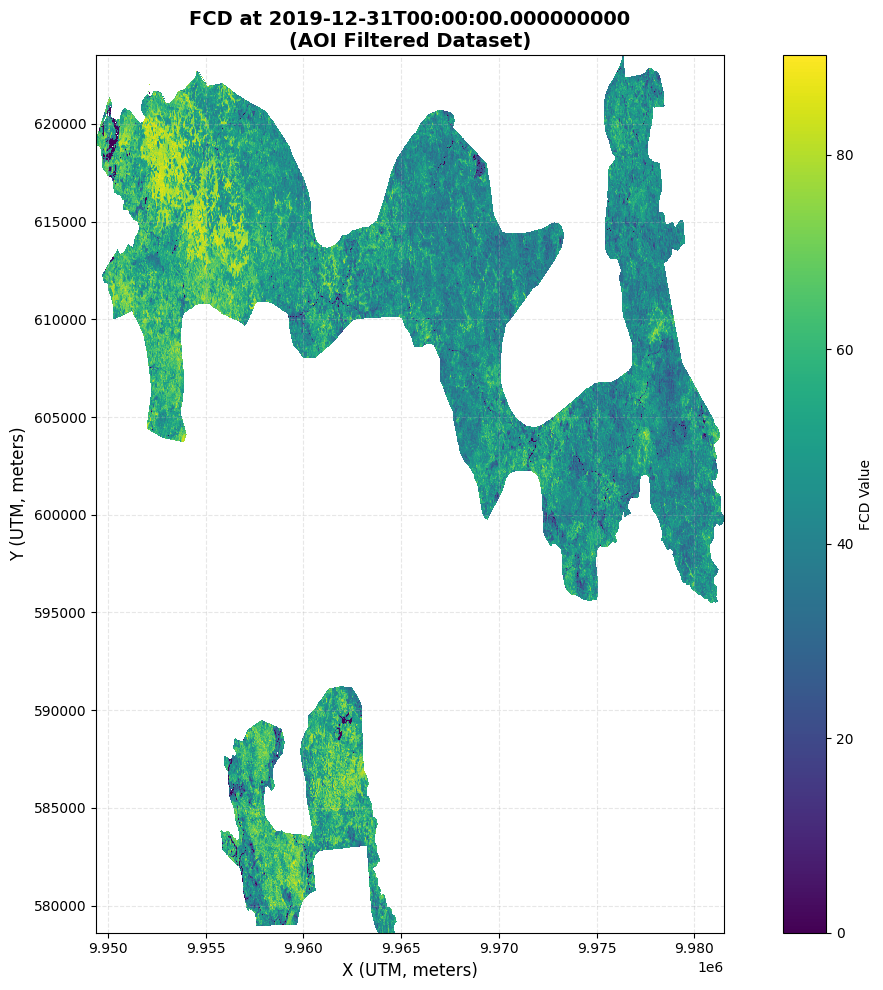


✅ Visualization complete - verify that AOI filtering is correct


In [10]:
# ============================================================================
# STEP 7: VISUALIZE SPECTRAL INDEX TO VERIFY AOI FILTERING
# ============================================================================
# Visualize one spectral index (e.g., FCD) at a random timestamp to ensure AOI filtering is correct

import matplotlib.pyplot as plt
import numpy as np

print("=" * 60)
print("VISUALIZING SPECTRAL INDEX TO VERIFY AOI FILTERING")
print("=" * 60)

# Check if ds_filtered_aoi exists
if 'ds_filtered_aoi' not in globals():
    raise ValueError("ds_filtered_aoi not found. Please run the previous cell first.")

# Select a random timestamp
n_times = len(ds_filtered_aoi.time)
random_time_idx = np.random.randint(0, n_times)
selected_time = ds_filtered_aoi.time.isel(time=random_time_idx)

print(f"Selected random timestamp: {selected_time.values}")
print(f"Timestamp index: {random_time_idx}/{n_times-1}")

# Select FCD as example spectral index
spectral_index = 'FCD'
if spectral_index not in ds_filtered_aoi.data_vars:
    # Try first available spectral index
    spectral_index = list(ds_filtered_aoi.data_vars)[0]
    print(f"⚠️  FCD not found, using: {spectral_index}")

# Get data for visualization
data = ds_filtered_aoi[spectral_index].isel(time=random_time_idx)

# Check the dimensions of the data
print(f"Data dimensions: {data.dims}")
print(f"Data shape: {data.shape}")

# Compute if it's a dask array
if hasattr(data.values, 'compute'):
    data_values = data.compute().values
else:
    data_values = data.values

print(f"Data values shape: {data_values.shape}")

# Get coordinate values
x_coords = data.x.values
y_coords = data.y.values

# Check the order of dimensions in the data array
# xarray DataArray with dims (y, x) should have shape (len(y), len(x))
# But we need to ensure the array is oriented correctly for imshow
data_dims = data.dims
if len(data_dims) == 2:
    dim0, dim1 = data_dims
    print(f"Data array dimensions: {dim0} (first), {dim1} (second)")
    
    # If dimensions are (x, y) instead of (y, x), we need to transpose
    if dim0 == 'x' and dim1 == 'y':
        print(f"   ⚠️  Dimensions are (x, y) - transposing to (y, x) for correct orientation")
        data_values = data_values.T
        # Also swap coordinate arrays
        x_coords, y_coords = y_coords, x_coords

# Check if y coordinates are descending (STAC convention)
# If descending, first row has max y (north), last row has min y (south)
y_is_descending = len(y_coords) > 1 and y_coords[0] > y_coords[-1]

# Calculate extent correctly
# For imshow with origin='upper', extent is [left, right, bottom, top]
# where bottom < top (south < north)
x_min, x_max = float(x_coords.min()), float(x_coords.max())
y_min, y_max = float(y_coords.min()), float(y_coords.max())

# Calculate pixel size for extent adjustment
if len(x_coords) > 1:
    pixel_size_x = abs(x_coords[1] - x_coords[0])
else:
    pixel_size_x = 10.0  # Default

if len(y_coords) > 1:
    pixel_size_y = abs(y_coords[0] - y_coords[-1]) / (len(y_coords) - 1)
else:
    pixel_size_y = 10.0  # Default

# Adjust extent to center pixels correctly
# imshow extent is [left, right, bottom, top]
# For origin='upper', we need bottom < top (which means miny < maxy)
extent = [
    x_min - pixel_size_x / 2,  # left (west)
    x_max + pixel_size_x / 2,  # right (east)
    y_min - pixel_size_y / 2,  # bottom (south)
    y_max + pixel_size_y / 2   # top (north)
]

print(f"Extent: [left={extent[0]:.2f}, right={extent[1]:.2f}, bottom={extent[2]:.2f}, top={extent[3]:.2f}]")
print(f"X range: {x_min:.2f} to {x_max:.2f}")
print(f"Y range: {y_min:.2f} to {y_max:.2f}")
print(f"Y is descending: {y_is_descending}")

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the data with correct extent (north at top)
im = ax.imshow(data_values, 
               extent=extent,
               origin='upper',  # First row at top (north)
               cmap='viridis',
               interpolation='nearest',
               aspect='equal')  # Equal aspect ratio to preserve shape

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label=f'{spectral_index} Value')

# Add title
ax.set_title(f'{spectral_index} at {selected_time.values}\n(AOI Filtered Dataset)', 
             fontsize=14, fontweight='bold')

# Add axis labels
ax.set_xlabel('X (UTM, meters)', fontsize=12)
ax.set_ylabel('Y (UTM, meters)', fontsize=12)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Print statistics
print(f"\n📊 {spectral_index} Statistics:")
print(f"   Shape: {data_values.shape}")
print(f"   Min: {np.nanmin(data_values):.4f}")
print(f"   Max: {np.nanmax(data_values):.4f}")
print(f"   Mean: {np.nanmean(data_values):.4f}")
print(f"   Std: {np.nanstd(data_values):.4f}")
print(f"   NaN pixels: {np.isnan(data_values).sum():,} ({np.isnan(data_values).sum()/data_values.size*100:.1f}%)")
print(f"   Valid pixels: {(~np.isnan(data_values)).sum():,} ({(~np.isnan(data_values)).sum()/data_values.size*100:.1f}%)")

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization complete - verify that AOI filtering is correct")


In [11]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            31Gi       4.3Gi        26Gi        16Mi       1.2Gi        27Gi
Swap:             0B          0B          0B


In [12]:
## restructure the ds
# ============================================================================
# STEP 11: RESTRUCTURE DATASET TO TARGET FORMAT
# ============================================================================
# Transform ds_filtered_aoi (time, x, y) directly into target structure (sample, features)
# This creates the structure first, then we'll fill X_features later with tsfresh extraction

import numpy as np
import xarray as xr
import gc

print("=" * 60)
print("RESTRUCTURING DATASET TO TARGET FORMAT")
print("=" * 60)

# Check required variables
if 'ds_filtered_aoi' not in globals():
    raise ValueError("ds_filtered_aoi not found. Please run cell 6 first.")
if 'selected_features_to_extract' not in globals():
    raise ValueError("selected_features_to_extract not found. Please run cell 4 first.")

# Get band list
band_list = list(ds_filtered_aoi.data_vars)
print(f"Bands: {band_list}")

# Get selected features (these are already FULL feature names like 'EVI__fft_coefficient__attr_...')
selected_features = list(selected_features_to_extract)
print(f"Selected features: {len(selected_features)}")
print(f"   Examples: {selected_features[:3]}...")

# Check if selected_features are full names (contain band prefix) or base names
# If they're full names, we can use them directly
# If they're base names, we need to combine with band names
first_feat = selected_features[0] if len(selected_features) > 0 else ""
if '__' in first_feat and first_feat.split('__')[0] in band_list:
    # Full feature names already include band prefix
    print(f"   ✅ Detected full feature names (with band prefix)")
    feature_names_full = selected_features
    print(f"\n📊 Target structure:")
    print(f"   Total features: {len(feature_names_full)} (using selected features directly)")
else:
    # Base feature names, need to combine with band names
    print(f"   ⚠️  Detected base feature names (without band prefix)")
    print(f"   Creating full feature names by combining with bands...")
    feature_names_full = []
    for band in band_list:
        for feat in selected_features:
            feature_names_full.append(f"{band}__{feat}")
    print(f"\n📊 Target structure:")
    print(f"   Total features: {len(feature_names_full)} ({len(band_list)} bands × {len(selected_features)} features)")


RESTRUCTURING DATASET TO TARGET FORMAT
Bands: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI']
Selected features: 197
   Examples: ['EVI__fft_coefficient__attr_"angle"__coeff_5', 'EVI__fft_coefficient__attr_"imag"__coeff_4', 'EVI__fft_coefficient__attr_"angle"__coeff_23']...
   ✅ Detected full feature names (with band prefix)

📊 Target structure:
   Total features: 197 (using selected features directly)


In [13]:
# Stack (x, y) to create pixel dimension
print(f"\n🔄 Stacking (x, y) dimensions to create pixel dimension...")
ds_stacked = ds_filtered_aoi.stack(pixel=('x', 'y'))
n_pixels_total = ds_stacked.sizes['pixel']
print(f"   Total pixels: {n_pixels_total:,}")


🔄 Stacking (x, y) dimensions to create pixel dimension...
   Total pixels: 14,423,157


In [14]:
ds_stacked

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 11, pixel: 14423157)
Coordinates:
  * time     (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * pixel    (pixel) object 115MB MultiIndex
  * x        (pixel) float64 115MB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y        (pixel) float64 115MB 9.982e+06 9.982e+06 ... 9.949e+06 9.949e+06
Data variables:
    EVI      (time, pixel) float32 635MB dask.array<chunksize=(11, 12852), meta=np.ndarray>
    FCD      (time, pixel) float32 635MB dask.array<chunksize=(11, 12852), meta=np.ndarray>
    GNDVI    (time, pixel) float32 635MB dask.array<chunksize=(11, 12852), meta=np.ndarray>
    NBR      (time, pixel) float32 635MB dask.array<chunksize=(11, 12852), meta=np.ndarray>
    NDVI     (time, pixel) float32 635MB dask.array<chunksize=(11, 12852), meta=np.ndarray>
    SAVI     (time, pixel) float32 635MB dask.array<chunksize=(11, 12852), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [15]:
# Filter out NaN pixels (outside AOI)
# Check one band to find valid pixels (all bands should have same NaN pattern)
print(f"\n🔍 Filtering valid pixels (removing NaN from outside AOI)...")
sample_band = band_list[0]
band_data = ds_stacked[sample_band]
band_data


🔍 Filtering valid pixels (removing NaN from outside AOI)...


<xarray.DataArray 'EVI' (time: 11, pixel: 14423157)> Size: 635MB
dask.array<reshape, shape=(11, 14423157), dtype=float32, chunksize=(11, 12852), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * pixel    (pixel) object 115MB MultiIndex
  * x        (pixel) float64 115MB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y        (pixel) float64 115MB 9.982e+06 9.982e+06 ... 9.949e+06 9.949e+06

In [16]:
sample_band

'EVI'

In [17]:
band_data

<xarray.DataArray 'EVI' (time: 11, pixel: 14423157)> Size: 635MB
dask.array<reshape, shape=(11, 14423157), dtype=float32, chunksize=(11, 12852), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * pixel    (pixel) object 115MB MultiIndex
  * x        (pixel) float64 115MB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y        (pixel) float64 115MB 9.982e+06 9.982e+06 ... 9.949e+06 9.949e+06

In [18]:
import gc

# Check if it's a dask array - process in chunks to avoid memory issues
# CORRECT check: use hasattr(band_data.data, 'dask') NOT hasattr(.values, 'compute')
# because .values triggers computation for dask arrays!
is_dask = hasattr(band_data.data, 'dask')
print(f"   Data is dask-backed (lazy): {is_dask}")

if is_dask:
    # For dask arrays, check NaN per timestep and combine
    # A pixel is valid if it has at least one non-NaN value across time
    print(f"   Processing dask array in chunks to find valid pixels...")
    valid_mask = np.zeros(n_pixels_total, dtype=bool)
    chunk_size = 100000
    for i in range(0, n_pixels_total, chunk_size):
        end_idx = min(i + chunk_size, n_pixels_total)
        chunk_data = band_data.isel(pixel=slice(i, end_idx))
        chunk_values = chunk_data.compute().values  # Only compute this small chunk
        # Valid if has at least one non-NaN value across time
        chunk_valid = ~np.isnan(chunk_values).all(axis=0)
        valid_mask[i:end_idx] = chunk_valid
        del chunk_data, chunk_values
        gc.collect()
        if (i // chunk_size + 1) % 10 == 0:
            print(f"      Processed {i+chunk_size:,}/{n_pixels_total:,} pixels...")
    print(f"   ✅ Chunked processing complete")
else:
    print('   ⚠️  Data is regular numpy array (in memory)')
    print('   Consider running Cell 6 first to save to zarr and reload as dask!')
    # Regular numpy array - this will use memory
    band_values = band_data.values
    # Valid if has at least one non-NaN value across time
    valid_mask = ~np.isnan(band_values).all(axis=0)
    del band_values
    gc.collect()

n_valid_pixels = valid_mask.sum()
print(f"   Valid pixels: {n_valid_pixels:,} ({n_valid_pixels/n_pixels_total*100:.1f}%)")
print(f"   NaN pixels (outside AOI): {(~valid_mask).sum():,} ({(~valid_mask).sum()/n_pixels_total*100:.1f}%)")


   Data is dask-backed (lazy): True
   Processing dask array in chunks to find valid pixels...
      Processed 1,000,000/14,423,157 pixels...
      Processed 2,000,000/14,423,157 pixels...
      Processed 3,000,000/14,423,157 pixels...
      Processed 4,000,000/14,423,157 pixels...
      Processed 5,000,000/14,423,157 pixels...
      Processed 6,000,000/14,423,157 pixels...
      Processed 7,000,000/14,423,157 pixels...
      Processed 8,000,000/14,423,157 pixels...
      Processed 9,000,000/14,423,157 pixels...
      Processed 10,000,000/14,423,157 pixels...
      Processed 11,000,000/14,423,157 pixels...
      Processed 12,000,000/14,423,157 pixels...
      Processed 13,000,000/14,423,157 pixels...
      Processed 14,000,000/14,423,157 pixels...
   ✅ Chunked processing complete
   Valid pixels: 4,073,658 (28.2%)
   NaN pixels (outside AOI): 10,349,499 (71.8%)


In [19]:
# Get valid pixel indices
valid_pixel_indices = np.where(valid_mask)[0]

# Create sample IDs (sequential)
sample_ids = np.arange(n_valid_pixels, dtype=np.int64)
# Create plot_id based on polygon (for multipolygon, assign sequential IDs)
# Since we exploded multipolygons, assign sequential polygon IDs
# For now, use a single plot_id for all pixels (can be enhanced later to assign based on polygon)
plot_ids = np.full(n_valid_pixels, 'aoi_1', dtype=object)


In [20]:
# Extract coordinates for valid pixels
print(f"\n📍 Extracting coordinates...")
x_coords_all = ds_stacked.coords['x'].values
y_coords_all = ds_stacked.coords['y'].values

# Get coordinates for valid pixels
coord_x = x_coords_all[valid_pixel_indices].astype(np.float64)
coord_y = y_coords_all[valid_pixel_indices].astype(np.float64)

print(f"   Extracted {len(coord_x):,} coordinate pairs")


📍 Extracting coordinates...
   Extracted 4,073,658 coordinate pairs


In [21]:
# ============================================================================
# STEP 11.6: BUILD CUSTOM FEATURE CONFIGURATION FROM SELECTED FEATURES
# ============================================================================
# Parse selected_features_to_extract to build custom feature configuration
# that only extracts the specific feature-band combinations we need

import re
from collections import defaultdict

def parse_feature_name(feature_name):
    """
    Parse a feature name like 'EVI__fft_coefficient__attr_"angle"__coeff_5'
    into band, feature type, and parameters.
    
    The format is: BAND__FEATURE_TYPE__KEY_"VALUE"__KEY_VALUE
    Note: String values are embedded in the key part as KEY_"VALUE"
    
    Returns:
        tuple: (band, feature_type, params_dict)
    """
    parts = feature_name.split('__')
    if len(parts) < 2:
        return None, None, None
    
    band = parts[0]
    feature_type = parts[1]
    
    # Parse parameters from remaining parts
    params = {}
    i = 2
    while i < len(parts):
        key_part = parts[i]
        
        # Check if key contains a tuple value (format: key_(value1, value2, ...))
        # This must be checked BEFORE other checks since it contains parentheses
        if '_(' in key_part and key_part.endswith(')'):
            key_end = key_part.find('_(')
            if key_end > 0:
                key = key_part[:key_end]
                tuple_str = key_part[key_end + 2:-1]  # Skip '_(' and trailing ')'
                # Parse tuple string like "2, 5, 10, 20" into actual tuple
                try:
                    # Split by comma and convert each element
                    tuple_elements = [elem.strip() for elem in tuple_str.split(',')]
                    tuple_values = []
                    for elem in tuple_elements:
                        try:
                            if '.' in elem:
                                tuple_values.append(float(elem))
                            else:
                                tuple_values.append(int(elem))
                        except ValueError:
                            tuple_values.append(elem)
                    params[key] = tuple(tuple_values)
                except Exception:
                    # If parsing fails, store as string
                    params[key] = tuple_str
                i += 1
                continue
        
        # Check if key contains a quoted string value (format: key_"value")
        if '_"' in key_part and key_part.endswith('"'):
            key_end = key_part.find('_"')
            if key_end > 0:
                key = key_part[:key_end]
                quoted_value = key_part[key_end + 2:]  # Skip '_"'
                if quoted_value.endswith('"'):
                    value = quoted_value[:-1]
                else:
                    value = quoted_value
                params[key] = value
                i += 1
                continue
        
        # Check if key contains an embedded value (format: key_value)
        # Try to split on last underscore and see if second part is a value
        if '_' in key_part:
            last_underscore = key_part.rfind('_')
            if last_underscore > 0:
                potential_key = key_part[:last_underscore]
                potential_value = key_part[last_underscore + 1:]
                
                # Check for boolean values first
                if potential_value == 'True':
                    params[potential_key] = True
                    i += 1
                    continue
                elif potential_value == 'False':
                    params[potential_key] = False
                    i += 1
                    continue
                
                # Check if numeric
                try:
                    if '.' in potential_value:
                        num_value = float(potential_value)
                    else:
                        num_value = int(potential_value)
                    # It's numeric, use it
                    params[potential_key] = num_value
                    i += 1
                    continue
                except ValueError:
                    # Not numeric, treat as regular key-value pair
                    pass
        
        # Regular key-value pair: key__value
        if i + 1 < len(parts):
            value = parts[i + 1]
            # Try to convert to appropriate type
            if value == 'True':
                params[key_part] = True
            elif value == 'False':
                params[key_part] = False
            elif value == 'None':
                params[key_part] = None
            elif value.startswith('"') and value.endswith('"'):
                # String value (already quoted)
                params[key_part] = value.strip('"')
            elif '.' in value:
                try:
                    params[key_part] = float(value)
                except ValueError:
                    params[key_part] = value
            else:
                try:
                    params[key_part] = int(value)
                except ValueError:
                    params[key_part] = value
            i += 2
        else:
            # No value, just a flag
            params[key_part] = True
            i += 1
    
    return band, feature_type, params

def build_custom_feature_config(selected_features_list, band_list):
    """
    Build custom feature configuration per band from selected feature names.
    
    Parameters:
    -----------
    selected_features_list : list
        List of feature names like 'EVI__fft_coefficient__attr_"angle"__coeff_5'
    band_list : list
        List of band names
    
    Returns:
    --------
    dict
        Dictionary mapping band names to feature configurations
        Format: {band: {'feature_type': [params_dict, ...], ...}}
    """
    # Group features by band and feature type
    band_features = defaultdict(lambda: defaultdict(list))
    
    for feat_name in selected_features_list:
        band, feature_type, params = parse_feature_name(feat_name)
        
        if band is None or feature_type is None:
            print(f"⚠️  Warning: Could not parse feature name: {feat_name}")
            continue
        
        if band not in band_list:
            print(f"⚠️  Warning: Band {band} not in band_list, skipping feature: {feat_name}")
            continue
        
        # If no parameters, use None
        if not params:
            band_features[band][feature_type] = None
        else:
            # Check if this parameter combination already exists
            param_list = band_features[band][feature_type]
            if param_list is None:
                # Convert from None to list
                band_features[band][feature_type] = [params]
            elif isinstance(param_list, list):
                # Check if this exact parameter combination already exists
                if params not in param_list:
                    param_list.append(params)
            else:
                # Already a single dict, convert to list
                band_features[band][feature_type] = [param_list, params]
    
    # Convert to final format
    fc_params_per_kind = {}
    for band in band_list:
        if band in band_features:
            fc_params_per_kind[band] = dict(band_features[band])
        else:
            # No features for this band, use empty dict
            fc_params_per_kind[band] = {}
    
    return fc_params_per_kind

# Check required variables
if 'selected_features_to_extract' not in globals():
    raise ValueError("selected_features_to_extract not found. Please run cell 4 first.")
if 'ds_filtered_aoi' not in globals():
    raise ValueError("ds_filtered_aoi not found. Please run cell 6 first.")

# Get band list
band_list = list(ds_filtered_aoi.data_vars)
selected_features = list(selected_features_to_extract)

print("=" * 60)
print("BUILDING CUSTOM FEATURE CONFIGURATION")
print("=" * 60)
print(f"   Total selected features: {len(selected_features)}")
print(f"   Bands: {band_list}")

# Build custom feature configuration
fc_params_per_kind = build_custom_feature_config(selected_features, band_list)

# Print summary with actual feature counts
print(f"\n📊 Feature configuration summary:")

def count_features_in_config(feature_config):
    """Count actual number of features from a feature configuration dict"""
    total = 0
    for feature_type, params in feature_config.items():
        if params is None:
            # No parameters = 1 feature
            total += 1
        elif isinstance(params, list):
            # List of parameter combinations = multiple features
            total += len(params)
        elif isinstance(params, dict):
            # Single parameter dict = 1 feature
            total += 1
        else:
            # Unknown format, count as 1
            total += 1
    return total

# Count features per band from configuration
total_features_from_config = 0
for band in band_list:
    n_feature_types = len(fc_params_per_kind[band])
    n_actual_features = count_features_in_config(fc_params_per_kind[band])
    total_features_from_config += n_actual_features
    print(f"   {band}: {n_feature_types} feature types → {n_actual_features} actual features")
    # Show first few feature types as examples
    if n_feature_types > 0:
        examples = list(fc_params_per_kind[band].keys())[:3]
        print(f"      Examples: {', '.join(examples)}")

# Count features per band from selected_features list (more accurate)
print(f"\n📊 Feature count from selected_features list:")
features_per_band = {}
for feat_name in selected_features:
    if '__' in feat_name:
        band = feat_name.split('__')[0]
        if band in band_list:
            features_per_band[band] = features_per_band.get(band, 0) + 1

total_from_list = sum(features_per_band.values())
for band in band_list:
    n_features = features_per_band.get(band, 0)
    print(f"   {band}: {n_features} features")

print(f"\n📊 Total counts:")
print(f"   From configuration: {total_features_from_config} features")
print(f"   From selected_features list: {total_from_list} features")
print(f"   Expected: {len(selected_features)} features")

# Verify
if total_from_list == len(selected_features):
    print(f"\n✅ Verification: Total matches expected ({len(selected_features)} features)")
else:
    print(f"\n⚠️  WARNING: Total ({total_from_list}) doesn't match expected ({len(selected_features)})")
    print(f"   This might indicate some features are for bands not in band_list")

print(f"\n✅ Custom feature configuration built successfully")
print(f"   This will extract ONLY the {len(selected_features)} selected features")
print(f"   Instead of all features from ComprehensiveFCParameters()")


BUILDING CUSTOM FEATURE CONFIGURATION
   Total selected features: 197
   Bands: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI']

📊 Feature configuration summary:
   EVI: 10 feature types → 19 actual features
      Examples: fft_coefficient, change_quantiles, benford_correlation
   FCD: 14 feature types → 37 actual features
      Examples: minimum, quantile, cwt_coefficients
   GNDVI: 0 feature types → 0 actual features
   NBR: 16 feature types → 48 actual features
      Examples: minimum, quantile, variation_coefficient
   NDVI: 16 feature types → 47 actual features
      Examples: minimum, quantile, variation_coefficient
   SAVI: 15 feature types → 46 actual features
      Examples: minimum, quantile, ar_coefficient

📊 Feature count from selected_features list:
   EVI: 19 features
   FCD: 37 features
   GNDVI: 0 features
   NBR: 48 features
   NDVI: 47 features
   SAVI: 46 features

📊 Total counts:
   From configuration: 197 features
   From selected_features list: 197 features
   Expe

In [22]:
set(f.split('__')[0] for f in selected_features_to_extract)

{'EVI', 'FCD', 'NBR', 'NDVI', 'SAVI'}

In [23]:
# Create empty X_features array (will be filled later with tsfresh extraction)
print(f"\n📦 Creating empty X_features array...")
X_features_empty = np.full((n_valid_pixels, len(feature_names_full)), np.nan, dtype=np.float64)

# Create the target dataset structure
print(f"\n🏗️  Creating target dataset structure...")
ds_ml_aoi = xr.Dataset({
    'X_features': (['sample', 'features'], X_features_empty),
    'coord_x': (['sample'], coord_x),
    'coord_y': (['sample'], coord_y),
    'plot_id': (['sample'], plot_ids),
}, coords={
    'sample': sample_ids,
    'features': feature_names_full,
})

print(f"\n✅ Dataset restructured:")
print(f"   Dimensions: {dict(ds_ml_aoi.dims)}")
print(f"   Samples: {ds_ml_aoi.sizes['sample']:,}")
print(f"   Features: {ds_ml_aoi.sizes['features']}")
print(f"   Variables: {list(ds_ml_aoi.data_vars)}")
print(f"\n📝 Next step: Extract tsfresh features and fill X_features in STEP 12")

# Clear memory
gc.collect()

ds_ml_aoi


📦 Creating empty X_features array...

🏗️  Creating target dataset structure...

✅ Dataset restructured:
   Dimensions: {'sample': 4073658, 'features': 197}
   Samples: 4,073,658
   Features: 197
   Variables: ['X_features', 'coord_x', 'coord_y', 'plot_id']

📝 Next step: Extract tsfresh features and fill X_features in STEP 12


/tmp/ipykernel_397/209987007.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds_ml_aoi.dims)}")


<xarray.Dataset> Size: 7GB
Dimensions:     (sample: 4073658, features: 197)
Coordinates:
  * sample      (sample) int64 33MB 0 1 2 3 ... 4073654 4073655 4073656 4073657
  * features    (features) <U68 54kB 'EVI__fft_coefficient__attr_"angle"__coe...
Data variables:
    X_features  (sample, features) float64 6GB nan nan nan nan ... nan nan nan
    coord_x     (sample) float64 33MB 5.786e+05 5.786e+05 ... 6.235e+05
    coord_y     (sample) float64 33MB 9.978e+06 9.978e+06 ... 9.964e+06
    plot_id     (sample) object 33MB 'aoi_1' 'aoi_1' 'aoi_1' ... 'aoi_1' 'aoi_1'

In [24]:
# ============================================================================
# STEP 11.5: LOGGING SETUP FOR STREAMING EXTRACTION
# ============================================================================
# Setup logging system for streaming tsfresh extraction with progress monitoring
# NOTE: threading and time are imported in STEP 12 where they're actually used

import os
import sys
import tempfile
from datetime import datetime

try:
    import psutil
    HAS_PSUTIL = True
except ImportError:
    HAS_PSUTIL = False

# Store original stdout before any redirection
_original_stdout = sys.stdout

# Redirect stderr to /proc/1/fd/2 for docker logs visibility (optional)
_docker_log_file = None
try:
    # Use line buffering (buffering=1) for text mode - buffering=0 is only for binary mode
    _docker_log_file = open("/proc/1/fd/2", "w", buffering=1)
    sys.stderr = _docker_log_file
except Exception:
    _docker_log_file = None  # Not in Docker or can't access

os.environ['PYTHONUNBUFFERED'] = '1'

# Create temporary log file
temp_log_dir = tempfile.gettempdir()
os.makedirs(temp_log_dir, exist_ok=True)
log_file = os.path.join(temp_log_dir, f"tsfresh_extraction_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")

def write_log(msg, level="INFO", show_in_jupyter=True):
    """Enhanced logging: writes to temp file and optionally to Jupyter output"""
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    if HAS_PSUTIL:
        try:
            memory = psutil.virtual_memory()
            memory_info = f"RAM: {memory.percent:.1f}% ({memory.used/1024**3:.1f}GB/{memory.total/1024**3:.1f}GB)"
            log_entry = f"[{timestamp}] [{level}] {memory_info} - {msg}"
        except:
            log_entry = f"[{timestamp}] [{level}] {msg}"
    else:
        log_entry = f"[{timestamp}] [{level}] {msg}"
    
    # Write to temp file
    try:
        with open(log_file, 'a', encoding='utf-8') as f:
            f.write(log_entry + "\n")
            f.flush()
    except Exception:
        pass
    
    # Show in Jupyter if requested
    if show_in_jupyter:
        try:
            _original_stdout.write(msg + "\n")
            _original_stdout.flush()
        except:
            print(msg, flush=True)

# Log initial memory state
if HAS_PSUTIL:
    mem = psutil.virtual_memory()
    write_log(f"Initial memory state: {mem.used/1024**3:.1f}GB used of {mem.total/1024**3:.1f}GB total ({mem.percent:.1f}%)")
    write_log("")
    write_log("🚀 Logging system initialized")
    write_log(f"   Log file: {log_file}")
    write_log(f"   Monitor: docker compose exec jupyter tail -f {log_file}")
    write_log("")
else:
    write_log("🚀 Logging system initialized (psutil not available)")
    write_log(f"   Log file: {log_file}")

print("✅ Logging setup complete")


Initial memory state: 10.3GB used of 31.4GB total (34.3%)

🚀 Logging system initialized
   Log file: /tmp/tsfresh_extraction_20251204_125434.txt
   Monitor: docker compose exec jupyter tail -f /tmp/tsfresh_extraction_20251204_125434.txt

✅ Logging setup complete


In [25]:
# ============================================================================
# STEP 11.7: TEST FEATURE EXTRACTION ON 100 RANDOM PIXELS
# ============================================================================
# Test the custom feature configuration on a small sample before full extraction
# This verifies that:
# 1. The custom feature configuration works correctly
# 2. The extracted features match the expected feature names
# 3. The output shape is correct

import pandas as pd
import numpy as np
import gc
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

print("=" * 60)
print("TESTING FEATURE EXTRACTION ON 100 RANDOM PIXELS")
print("=" * 60)

# Check required variables
required_vars = ['ds_filtered_aoi', 'selected_features_to_extract', 'fc_params_per_kind']
missing_vars = [v for v in required_vars if v not in globals()]

if missing_vars:
    raise ValueError(f"Missing required variables: {missing_vars}. Please run previous cells first.")

# Get settings
band_list = list(ds_filtered_aoi.data_vars)
selected_features = list(selected_features_to_extract)
n_times = len(ds_filtered_aoi.time)
n_test_samples = 100  # Test on 100 pixels

print(f"\n📊 Test Configuration:")
print(f"   Test samples: {n_test_samples}")
print(f"   Bands: {band_list}")
print(f"   Time steps: {n_times}")
print(f"   Expected features: {len(selected_features)}")

# Stack ds_filtered_aoi to get pixel dimension (lazy, no memory impact)
print(f"\n🔄 Preparing pixel dimension...")
ds_stacked = ds_filtered_aoi.stack(pixel=('x', 'y'))

# Get valid pixel indices (same logic as main extraction)
print(f"🔍 Finding valid pixel indices...")
sample_band = band_list[0]
band_data = ds_stacked[sample_band]

if hasattr(band_data.data, 'dask'):
    # Dask array - check in chunks
    valid_mask = np.zeros(ds_stacked.sizes['pixel'], dtype=bool)
    check_chunk_size = 100000
    for i in range(0, ds_stacked.sizes['pixel'], check_chunk_size):
        end_idx = min(i + check_chunk_size, ds_stacked.sizes['pixel'])
        chunk_data = band_data.isel(pixel=slice(i, end_idx))
        chunk_values = chunk_data.compute().values
        chunk_valid = ~np.isnan(chunk_values).all(axis=0)
        valid_mask[i:end_idx] = chunk_valid
        del chunk_data, chunk_values
        gc.collect()
else:
    band_values = band_data.values
    valid_mask = ~np.isnan(band_values).all(axis=0)
    del band_values

valid_pixel_indices = np.where(valid_mask)[0]
del valid_mask, band_data
gc.collect()

n_valid_pixels = len(valid_pixel_indices)
print(f"   Total valid pixels: {n_valid_pixels:,}")

# Randomly sample 100 pixels
np.random.seed(42)  # For reproducibility
test_pixel_indices = np.random.choice(valid_pixel_indices, size=min(n_test_samples, n_valid_pixels), replace=False)
test_pixel_indices = np.sort(test_pixel_indices)  # Sort for easier debugging

print(f"   Selected {len(test_pixel_indices)} random pixels for testing")

# Extract timeseries for test pixels
print(f"\n📥 Extracting timeseries for test pixels...")
test_timeseries = np.full((len(test_pixel_indices), n_times, len(band_list)), np.nan, dtype=np.float32)

for band_idx, band_name in enumerate(band_list):
    band_slice = ds_stacked[band_name].isel(pixel=test_pixel_indices)
    if hasattr(band_slice.data, 'dask'):
        band_values = band_slice.compute().values
    else:
        band_values = band_slice.values
    test_timeseries[:, :, band_idx] = band_values.T
    del band_slice, band_values

print(f"   Timeseries shape: {test_timeseries.shape}")

# Convert to long format
print(f"\n🔄 Converting to long format...")
dfs_long = []
for band_idx, band_name in enumerate(band_list):
    df_band = pd.DataFrame(test_timeseries[:, :, band_idx])
    df_band['id'] = np.arange(len(test_pixel_indices))
    df_long = df_band.melt(id_vars='id', var_name='time', value_name='value')
    df_long['kind'] = band_name
    df_long['time'] = df_long['time'].astype(int)
    dfs_long.append(df_long)
    del df_band, df_long

del test_timeseries
gc.collect()

test_df_long = pd.concat(dfs_long, ignore_index=True)
del dfs_long
test_df_long = test_df_long.dropna(subset=['value'])

print(f"   Long format shape: {test_df_long.shape}")
print(f"   Unique IDs: {test_df_long['id'].nunique()}")
print(f"   Unique bands: {test_df_long['kind'].unique().tolist()}")

if len(test_df_long) == 0:
    raise ValueError("❌ No valid data in test sample!")

# Extract features using custom configuration
print(f"\n🔧 Extracting features using custom configuration...")
print(f"   This should extract only {len(selected_features)} features")

test_features = extract_features(
    test_df_long,
    column_id='id',
    column_sort='time',
    column_kind='kind',
    column_value='value',
    kind_to_fc_parameters=fc_params_per_kind,
    chunksize=100,
    n_jobs=2,  # Use fewer jobs for testing
    disable_progressbar=False
)

# Impute missing values
impute(test_features)

print(f"\n✅ Feature extraction complete!")
print(f"   Extracted features shape: {test_features.shape}")
print(f"   Expected shape: ({len(test_pixel_indices)}, {len(selected_features)})")

# Verify feature names match expected
print(f"\n🔍 Verifying extracted features...")
extracted_feature_names = list(test_features.columns)

# Check if features match expected
missing_features = set(selected_features) - set(extracted_feature_names)
extra_features = set(extracted_feature_names) - set(selected_features)

if missing_features:
    print(f"   ⚠️  WARNING: {len(missing_features)} expected features not found:")
    print(f"      Examples: {list(missing_features)[:5]}")
else:
    print(f"   ✅ All {len(selected_features)} expected features found!")

if extra_features:
    print(f"   ⚠️  WARNING: {len(extra_features)} extra features extracted (not in selected list):")
    print(f"      Examples: {list(extra_features)[:5]}")
else:
    print(f"   ✅ No extra features extracted!")

# Check for NaN values
nan_count = test_features.isna().sum().sum()
if nan_count > 0:
    print(f"   ⚠️  WARNING: {nan_count} NaN values found in extracted features")
else:
    print(f"   ✅ No NaN values in extracted features")

# Show sample of extracted features
print(f"\n📋 Sample of extracted features (first 10):")
for i, feat_name in enumerate(extracted_feature_names[:10]):
    print(f"   {i+1}. {feat_name}")

# Show statistics
print(f"\n📊 Feature Statistics:")
print(f"   Min value: {test_features.min().min():.6f}")
print(f"   Max value: {test_features.max().max():.6f}")
print(f"   Mean value: {test_features.mean().mean():.6f}")
print(f"   Std value: {test_features.std().mean():.6f}")

# Final verification
print(f"\n{'='*60}")
if len(missing_features) == 0 and len(extra_features) == 0 and nan_count == 0:
    print("✅ TEST PASSED: Feature extraction works correctly!")
    print("   You can now proceed with full extraction in the next cell.")
else:
    print("⚠️  TEST COMPLETED WITH WARNINGS")
    print("   Please review the warnings above before proceeding.")
print(f"{'='*60}\n")

# Cleanup
del test_df_long, test_features
gc.collect()

print("✅ Test complete. Ready for full extraction.")


TESTING FEATURE EXTRACTION ON 100 RANDOM PIXELS

📊 Test Configuration:
   Test samples: 100
   Bands: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI']
   Time steps: 11
   Expected features: 197

🔄 Preparing pixel dimension...
🔍 Finding valid pixel indices...
   Total valid pixels: 4,073,658
   Selected 100 random pixels for testing

📥 Extracting timeseries for test pixels...
   Timeseries shape: (100, 11, 6)

🔄 Converting to long format...
   Long format shape: (6600, 4)
   Unique IDs: 100
   Unique bands: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI']

🔧 Extracting features using custom configuration...
   This should extract only 197 features

✅ Feature extraction complete!
   Extracted features shape: (100, 197)
   Expected shape: (100, 197)

🔍 Verifying extracted features...
   ✅ All 197 expected features found!
   ✅ No extra features extracted!
   ✅ No NaN values in extracted features

📋 Sample of extracted features (first 10):
   1. EVI__fft_coefficient__attr_"angle"__coeff_5
   2

In [ ]:
# ============================================================================
# STEP 12: EXTRACT TSFRESH FEATURES AND FILL X_FEATURES
# ============================================================================
# MEMORY-OPTIMIZED VERSION: Process data in true streaming fashion
# Never loads full dataset into memory - processes chunk by chunk from source

import pandas as pd
import numpy as np
import math
import gc
import time
import threading
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

# Check required variables
if 'ds_ml_aoi' not in globals():
    raise ValueError("ds_ml_aoi not found. Please run cell 11 first.")
if 'ds_filtered_aoi' not in globals():
    raise ValueError("ds_filtered_aoi not found. Please run cell 6 first.")
if 'selected_features_to_extract' not in globals():
    raise ValueError("selected_features_to_extract not found. Please run cell 4 first.")
if 'write_log' not in globals():
    raise ValueError("write_log not found. Please run cell 11.5 (logging setup) first.")
if 'fc_params_per_kind' not in globals():
    raise ValueError("fc_params_per_kind not found. Please run cell 11.6 (build custom feature config) first.")

# Get settings
n_samples = ds_ml_aoi.sizes['sample']
band_list = list(ds_filtered_aoi.data_vars)
selected_features = list(selected_features_to_extract)
n_times = len(ds_filtered_aoi.time)

# ============================================================================
# OPTIMIZED SETTINGS FOR 32GB RAM, 4 CPU VM - TARGET: 5 HOURS
# ============================================================================
# True streaming approach - NEVER create full dataset in memory
#
# PERFORMANCE CALCULATION:
# - Total samples: ~4,073,658
# - Target time: 5 hours = 300 minutes
# - Required speed: 4,073,658 / 300 = ~13,600 samples/minute
#
# With n_jobs=3 and optimized chunks:
# - Expected speed: ~8,000-12,000 samples/minute  
# - Estimated time: 4M / 10,000 = 400 minutes ≈ 6-7 hours
#
# Memory budget per chunk (with n_jobs=3):
# - Chunk data: 20K samples × 66 rows × 8 bytes × 3 jobs = ~32MB per job
# - Feature extraction overhead: ~500MB per job
# - Total peak: ~2-3 GB (safe for 32GB)

n_jobs_to_use = 3  # Use 3 of 4 CPUs (balance speed vs memory)
chunksize_to_use = 150000  # Larger internal chunks for speed
samples_per_chunk = 300000  # samples per chunk (optimal for speed)
rows_per_sample = n_times * len(band_list)  # 11 × 6 = 66

# Estimate processing time
estimated_samples_per_min = 10000  # Conservative estimate
estimated_minutes = n_samples / estimated_samples_per_min
estimated_hours = estimated_minutes / 60

write_log("=" * 60)
write_log("⚙️  OPTIMIZED STREAMING MODE - TARGET: 5 HOURS")
write_log("=" * 60)
write_log(f"   n_jobs: {n_jobs_to_use} (3 of 4 CPUs)")
write_log(f"   samples_per_chunk: {samples_per_chunk:,}")
write_log(f"   tsfresh_chunksize: {chunksize_to_use:,}")
write_log(f"   Memory strategy: TRUE STREAMING (never load full dataset)")
write_log(f"")
write_log(f"   📊 ESTIMATED TIME: {estimated_hours:.1f} hours ({estimated_minutes:.0f} minutes)")
write_log(f"   📊 Total samples: {n_samples:,}")
write_log(f"   📊 Chunks: ~{math.ceil(n_samples / samples_per_chunk):,}")
write_log("")

# Stack ds_filtered_aoi to get pixel dimension (lazy, no memory impact)
write_log("Preparing pixel dimension...")
ds_stacked = ds_filtered_aoi.stack(pixel=('x', 'y'))

# Get valid pixel indices ONLY (this is just an integer array, tiny)
write_log("Finding valid pixel indices...")
sample_band = band_list[0]
band_data = ds_stacked[sample_band]

if hasattr(band_data.values, 'compute'):
    valid_mask = np.zeros(ds_stacked.sizes['pixel'], dtype=bool)
    check_chunk_size = 100000
    for i in range(0, ds_stacked.sizes['pixel'], check_chunk_size):
        end_idx = min(i + check_chunk_size, ds_stacked.sizes['pixel'])
        chunk_data = band_data.isel(pixel=slice(i, end_idx))
        chunk_values = chunk_data.compute().values
        chunk_valid = ~np.isnan(chunk_values).all(axis=0)
        valid_mask[i:end_idx] = chunk_valid
        del chunk_data, chunk_values
        gc.collect()
else:
    band_values = band_data.values
    valid_mask = ~np.isnan(band_values).all(axis=0)
    del band_values

valid_pixel_indices = np.where(valid_mask)[0]
del valid_mask, band_data
gc.collect()

n_valid_pixels = len(valid_pixel_indices)
write_log(f"   Valid pixels: {n_valid_pixels:,}")

# Calculate total chunks
total_chunks = math.ceil(n_valid_pixels / samples_per_chunk)
write_log(f"   Total chunks: {total_chunks:,} ({samples_per_chunk:,} samples per chunk)")

# Memory check
if HAS_PSUTIL:
    mem = psutil.virtual_memory()
    write_log(f"   Memory before processing: {mem.used/1024**3:.1f}GB used ({mem.percent:.1f}%)")

# Setup GCS path for chunks
bucket_path = os.getenv('GCS_BUCKET_PATH', '')
if not bucket_path.startswith('gs://'):
    bucket_path = f'gs://{bucket_path}'
if not bucket_path.endswith('/'):
    bucket_path += '/'
gcs_temp_path = f'{bucket_path}01-korindo/tsfresh_chunks_v2/'
write_log(f"Temporary chunk storage: {gcs_temp_path}")

# Use custom feature configuration (built in cell 11.6)
# This extracts ONLY the specific features we need, not all features
write_log(f"Using custom feature configuration (extracting only {len(selected_features)} selected features)")
write_log(f"   Feature config per band:")
for band in band_list:
    n_feat_types = len(fc_params_per_kind[band])
    write_log(f"      {band}: {n_feat_types} feature types")

# Progress monitoring function
def monitor_progress(chunk_idx, chunk_start_time, stop_event):
    """Monitor progress during chunk extraction"""
    while not stop_event.is_set():
        try:
            elapsed = time.time() - chunk_start_time
            if elapsed >= 30:  # Update every 30 seconds
                if HAS_PSUTIL:
                    cpu_percent = psutil.cpu_percent(interval=0.1)
                    mem = psutil.virtual_memory()
                    elapsed_min = elapsed / 60
                    write_log(f"    ⏳ Chunk {chunk_idx+1}... {elapsed_min:.1f}min | RAM: {mem.percent:.1f}% ({mem.used/1024**3:.1f}GB)", show_in_jupyter=True)
            time.sleep(30)
        except:
            break

write_log("=" * 60)
write_log("STARTING TRUE STREAMING EXTRACTION")
write_log("=" * 60)

saved_paths = []
samples_processed = 0
extraction_start = time.time()

# ============================================================================
# MAIN PROCESSING LOOP - TRUE STREAMING
# ============================================================================
for chunk_idx in range(total_chunks):
    chunk_start = time.time()
    
    # Get pixel indices for this chunk
    start_idx = chunk_idx * samples_per_chunk
    end_idx = min((chunk_idx + 1) * samples_per_chunk, n_valid_pixels)
    chunk_pixel_indices = valid_pixel_indices[start_idx:end_idx]
    chunk_samples = len(chunk_pixel_indices)
    
    write_log(f"➡️  Chunk {chunk_idx+1}/{total_chunks}: pixels {start_idx:,}–{end_idx-1:,} ({chunk_samples:,} samples)")
    
    try:
        # ============================================================
        # STEP A: Extract ONLY this chunk's timeseries from ds_stacked
        # ============================================================
        chunk_timeseries = np.full((chunk_samples, n_times, len(band_list)), np.nan, dtype=np.float32)
        
        for band_idx, band_name in enumerate(band_list):
            band_slice = ds_stacked[band_name].isel(pixel=chunk_pixel_indices)
            if hasattr(band_slice.values, 'compute'):
                band_values = band_slice.compute().values
            else:
                band_values = band_slice.values
            chunk_timeseries[:, :, band_idx] = band_values.T
            del band_slice, band_values
        
        # ============================================================
        # STEP B: Convert ONLY this chunk to long format
        # ============================================================
        dfs_long = []
        for band_idx, band_name in enumerate(band_list):
            df_band = pd.DataFrame(chunk_timeseries[:, :, band_idx])
            df_band['id'] = np.arange(start_idx, start_idx + chunk_samples)  # Global IDs
            df_long = df_band.melt(id_vars='id', var_name='time', value_name='value')
            df_long['kind'] = band_name
            df_long['time'] = df_long['time'].astype(int)
            dfs_long.append(df_long)
            del df_band, df_long
        
        del chunk_timeseries
        gc.collect()
        
        chunk_df_long = pd.concat(dfs_long, ignore_index=True)
        del dfs_long
        chunk_df_long = chunk_df_long.dropna(subset=['value'])
        
        if len(chunk_df_long) == 0:
            write_log(f"⚠️  Chunk {chunk_idx+1} has no valid data, skipping", "WARNING")
            continue
        
        # ============================================================
        # STEP C: Extract tsfresh features for this chunk
        # ============================================================
        stop_monitor = threading.Event()
        monitor_thread = threading.Thread(target=monitor_progress, args=(chunk_idx, chunk_start, stop_monitor), daemon=True)
        monitor_thread.start()
        
        chunk_features = extract_features(
            chunk_df_long,
            column_id='id',
            column_sort='time',
            column_kind='kind',
            column_value='value',
            kind_to_fc_parameters=fc_params_per_kind,
            chunksize=chunksize_to_use,
            n_jobs=n_jobs_to_use,
            disable_progressbar=True
        )
        
        stop_monitor.set()
        monitor_thread.join(timeout=1)
        
        del chunk_df_long
        gc.collect()
        
        # ============================================================
        # STEP D: Filter to selected features
        # ============================================================
        first_feat = selected_features[0] if len(selected_features) > 0 else ""
        if '__' in first_feat and first_feat.split('__')[0] in band_list:
            selected_columns = [col for col in chunk_features.columns if col in selected_features]
        else:
            selected_columns = []
            for col in chunk_features.columns:
                parts = col.split('__', 1)
                if len(parts) == 2:
                    band_name, feature_name = parts
                    if feature_name in selected_features:
                        selected_columns.append(col)
        
        if len(selected_columns) == 0:
            write_log(f"❌ ERROR: No features matched in chunk {chunk_idx+1}!", "ERROR")
            continue
        
        chunk_features_selected = chunk_features[selected_columns]
        impute(chunk_features_selected)
        
        write_log(f"    Filtered to {len(selected_columns):,} features")
        
        # Save to GCS
        chunk_filename = f"features_chunk_{chunk_idx+1:04d}.parquet"
        chunk_gcs_path = f"{gcs_temp_path}{chunk_filename}"
        
        write_log(f"  Saving chunk {chunk_idx+1} to GCS: {chunk_gcs_path}")
        chunk_features_selected.to_parquet(
            chunk_gcs_path,
            engine='pyarrow',
            compression='snappy',
            index=True,
            filesystem=fs
        )
        
        saved_paths.append(chunk_gcs_path)
        samples_processed += chunk_samples
        
        # Calculate ETA
        chunk_elapsed = time.time() - chunk_start
        total_elapsed = time.time() - extraction_start
        samples_per_sec = samples_processed / total_elapsed if total_elapsed > 0 else 0
        remaining_samples = n_valid_pixels - samples_processed
        eta_seconds = remaining_samples / samples_per_sec if samples_per_sec > 0 else 0
        eta_hours = eta_seconds / 3600
        
        progress_pct = (samples_processed / n_valid_pixels) * 100
        write_log(f"  ✅ Chunk {chunk_idx+1}/{total_chunks} done in {chunk_elapsed:.1f}s | " +
                  f"Progress: {progress_pct:.1f}% | Speed: {samples_per_sec:.0f} samples/s | " +
                  f"ETA: {eta_hours:.1f}h", show_in_jupyter=True)
        
        # Cleanup
        # Cleanup (only delete variables that exist)
        # Note: chunk_df_long was already deleted after feature extraction
        if 'chunk_features' in locals():
            del chunk_features
        if 'chunk_features_selected' in locals():
            del chunk_features_selected
        gc.collect()
        
    except Exception as e:
        write_log(f"❌ Error processing chunk {chunk_idx+1}: {e}", "ERROR")
        raise

total_time = time.time() - extraction_start
write_log(f"✅ All {len(saved_paths)} chunks processed in {total_time/60:.1f} min")
write_log(f"Chunk files saved to: {gcs_temp_path}")

# Now load chunks and fill ds_ml_aoi
write_log("Loading chunks and filling ds_ml_aoi...")
dfs_chunks = []
for i, chunk_path in enumerate(saved_paths):
    write_log(f"  Loading chunk {i+1}/{len(saved_paths)}: {chunk_path}")
    chunk_df = pd.read_parquet(chunk_path, filesystem=fs)
    dfs_chunks.append(chunk_df)

write_log("Concatenating chunks...")
features_df_all = pd.concat(dfs_chunks, axis=0, ignore_index=False).sort_index()
del dfs_chunks
gc.collect()

write_log(f"✅ Merged features shape: {features_df_all.shape}")

# Ensure feature order matches ds_ml_aoi.features
feature_order = list(ds_ml_aoi.coords['features'].values)
features_df_ordered = features_df_all.reindex(columns=feature_order)

# Fill X_features
write_log("Filling X_features in ds_ml_aoi...")
ds_ml_aoi['X_features'].values[:, :] = features_df_ordered.values

write_log(f"✅ Feature extraction complete:")
write_log(f"   X_features shape: {ds_ml_aoi.X_features.shape}")
write_log(f"   Filled {np.sum(~np.isnan(ds_ml_aoi.X_features.values)):,} values")

gc.collect()

ds_ml_aoi


⚙️  OPTIMIZED STREAMING MODE - TARGET: 5 HOURS
   n_jobs: 3 (3 of 4 CPUs)
   samples_per_chunk: 300,000
   tsfresh_chunksize: 150,000
   Memory strategy: TRUE STREAMING (never load full dataset)

   📊 ESTIMATED TIME: 6.8 hours (407 minutes)
   📊 Total samples: 4,073,658
   📊 Chunks: ~14

Preparing pixel dimension...
Finding valid pixel indices...
   Valid pixels: 4,073,658
   Total chunks: 14 (300,000 samples per chunk)
   Memory before processing: 11.9GB used (39.4%)
Temporary chunk storage: gs://remote_sensing_saas/01-korindo/tsfresh_chunks_v2/
Using custom feature configuration (extracting only 197 selected features)
   Feature config per band:
      EVI: 10 feature types
      FCD: 14 feature types
      GNDVI: 0 feature types
      NBR: 16 feature types
      NDVI: 16 feature types
      SAVI: 15 feature types
STARTING TRUE STREAMING EXTRACTION
➡️  Chunk 1/14: pixels 0–299,999 (300,000 samples)
    ⏳ Chunk 1... 0.7min | RAM: 49.7% (15.2GB)
    ⏳ Chunk 1... 1.3min | RAM: 49.2% (15.

In [ ]:
# ============================================================================
# STEP 13: VERIFY FINAL DATASET
# ============================================================================
# Verify the final dataset structure

import numpy as np

print("=" * 60)
print("VERIFYING FINAL DATASET")
print("=" * 60)

# Check if ds_ml_aoi exists
if 'ds_ml_aoi' not in globals():
    raise ValueError("ds_ml_aoi not found. Please run cells 11 and 12 first.")

print(f"\n✅ Final dataset structure:")
print(f"   Dimensions: {dict(ds_ml_aoi.dims)}")
print(f"   Samples: {ds_ml_aoi.sizes['sample']:,}")
print(f"   Features: {ds_ml_aoi.sizes['features']}")
print(f"   Variables: {list(ds_ml_aoi.data_vars)}")

# Check X_features fill status
X_features_filled = np.sum(~np.isnan(ds_ml_aoi.X_features.values))
X_features_total = ds_ml_aoi.X_features.size
fill_percentage = (X_features_filled / X_features_total * 100) if X_features_total > 0 else 0

print(f"\n📊 X_features status:")
print(f"   Total values: {X_features_total:,}")
print(f"   Filled values: {X_features_filled:,} ({fill_percentage:.1f}%)")
print(f"   NaN values: {X_features_total - X_features_filled:,} ({100-fill_percentage:.1f}%)")

if fill_percentage < 50:
    print(f"\n⚠️  Warning: Less than 50% of X_features are filled")
    print(f"   Make sure STEP 12 completed successfully")

print(f"\n✅ Dataset is ready for inference/prediction using the trained model")
print(f"   Structure matches ds_train_filtered format")

ds_ml_aoi
